In [6]:
import pandas as pd
import json
import requests

from io import BytesIO
from PIL import Image as PImage, ImageDraw as PImageDraw

from huggingface_hub import hf_hub_download
from ultralytics import YOLO

In [7]:
portrait_df = pd.read_csv("https://raw.githubusercontent.com/nmolnar-parsons/major-studio-1/refs/heads/main/Project_2/Data/cleaned_test.csv")
portrait_df

,Unnamed: 0,collectionsURL,unitCode,dataSource,title,EDANid,guid,recordLink,lastUpdateDate,creditLine,...,indexed_names,indexed_object_types,indexed_places,indexed_topics,mediaCount,mediaURLs,thumbnail,Sitter,Artist,Clean_Date
0,0,https://collections.si.edu/search/detail/edanm...,SAAM,Smithsonian American Art Museum,George Washington,edanmdm:saam_XX108A,http://n2t.net/ark:/65665/vk7c06aa8a1-8da1-47c...,https://americanart.si.edu/collections/search/...,2024-11-22,"{""Credit Line"": ""Smithsonian American Art Muse...",...,"['Washington, George', 'Winstanley, William']",[Paintings],[],"[Occupations, Men, Portraits, Political, Presi...",1,['https://ids.si.edu/ids/deliveryService?id=SA...,https://ids.si.edu/ids/iiif/SAAM-XX108A_1/full...,George Washington,William Winstanley,1803
1,1,https://collections.si.edu/search/detail/edanm...,SAAM,Smithsonian American Art Museum,Mourning Piece for George Washington,edanmdm:saam_1971.111,http://n2t.net/ark:/65665/vk7b2f8e20a-81fb-4f2...,https://americanart.si.edu/collections/search/...,2024-11-22,"{""Credit Line"": ""Smithsonian American Art Muse...",...,"['Washington, George', 'Gridley, Enoch G.']",[Graphic arts],[Washington],"[Soldiers, Memorials, Occupations, Men, Monume...",1,['https://ids.si.edu/ids/deliveryService?id=SA...,https://ids.si.edu/ids/iiif/SAAM-1971.111_1/fu...,George Washington,Enoch G. Gridley,1810
2,2,https://collections.si.edu/search/detail/edanm...,SAAM,Smithsonian American Art Museum,George Washington,edanmdm:saam_1971.102,http://n2t.net/ark:/65665/vk74652dc00-4f71-488...,https://americanart.si.edu/collections/search/...,2024-11-22,"{""Credit Line"": ""Smithsonian American Art Muse...",...,"['Washington, George', 'Fiquet, H.', 'Trumbull...",[Graphic arts],[],"[Uniforms, Landscapes, Animals, Occupations, C...",1,['https://ids.si.edu/ids/deliveryService?id=SA...,https://ids.si.edu/ids/iiif/SAAM-1971.102_1/fu...,George Washington,NaN,1800
3,3,https://collections.si.edu/search/detail/edanm...,NPG,National Portrait Gallery,Benjamin Franklin,edanmdm:npg_S_NPG.87.222,http://n2t.net/ark:/65665/sm4c77a42c7-3a26-4b6...,https://npg.si.edu/object/npg_S_NPG.87.222,2025-03-19,"{""Credit Line"": ""National Portrait Gallery, Sm...",...,"['Franklin, Benjamin', 'Pelicier, J.']","[Maps, Prints]",[],"[Social Welfare and Reform, Business and Finan...",1,['https://ids.si.edu/ids/deliveryService?id=NP...,https://ids.si.edu/ids/iiif/NPG-S_NPG_87_222/f...,Benjamin Franklin,J. Pelicier,1782
4,4,https://collections.si.edu/search/detail/edanm...,NPG,National Portrait Gallery,George Washington,edanmdm:npg_S_NPG.85.297,http://n2t.net/ark:/65665/sm4b8e95381-ee00-454...,https://npg.si.edu/object/npg_S_NPG.85.297,2025-05-17,"{""Credit Line"": ""National Portrait Gallery, Sm...",...,"['Du Simitiere, Pierre Eugene', United States....",[Prints],[United States],"[Business and Finance, Congressional Gold Meda...",1,['https://ids.si.edu/ids/deliveryService?id=NP...,https://ids.si.edu/ids/iiif/NPG-S-NPG_85_297/f...,George Washington,Louis Charles Ruotte,1796
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152,152,https://collections.si.edu/search/detail/edanm...,NPG,National Portrait Gallery,Alexander Hamilton,edanmdm:npg_NPG.2003.72,http://n2t.net/ark:/65665/sm4e9c8bb92-5e05-4d8...,https://npg.si.edu/object/npg_NPG.2003.72,2025-03-20,"{""Credit Line"": ""National Portrait Gallery, Sm...",...,"['Graham, George', United States. Army, 'Hamil...",[Prints],[],"[Legislators, Books and reading, Arts and Cult...",1,['https://ids.si.edu/ids/deliveryService?id=NP...,https://ids.si.edu/ids/iiif/NPG-NPG_2003_72Ham...,Alexander Hamilton,George Graham,1800
153,153,https://collections.si.edu/search/detail/edanm...,NPG,National Portrait Gallery,George Washington,edanmdm:npg_NPG.2002.384,http://n2t.net/ark:/65665/sm4c1771bc3-446a-466...,https://npg.si.edu/object/npg_NPG.2002.384,2025-03-19,"{""Credit Line"": ""National Portrait Gallery, Sm...",...,"[United States. Army, 'Washington, Geo

In [8]:
yolo_model_path = hf_hub_download(repo_id="AdamCodd/YOLOv11n-face-detection", filename="model.pt")
face_detector = YOLO(yolo_model_path)

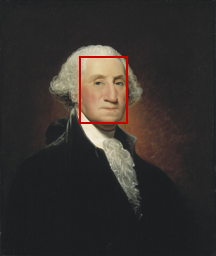

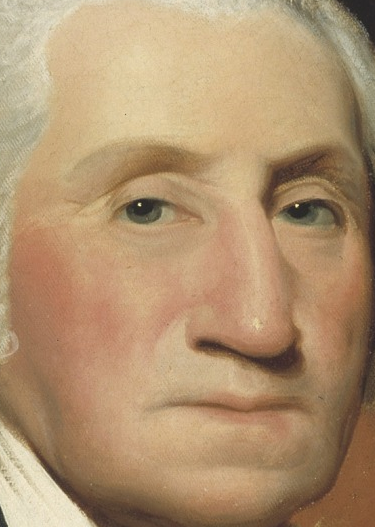

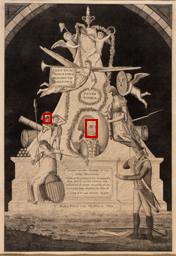

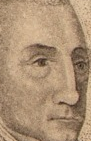

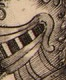

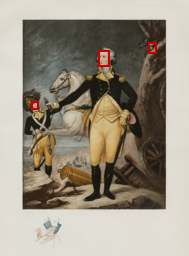

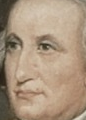

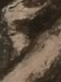

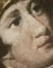

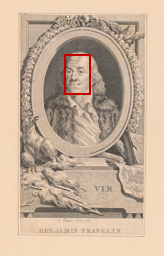

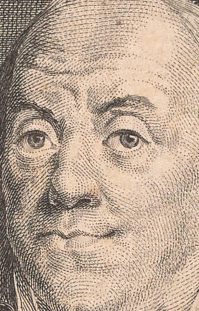

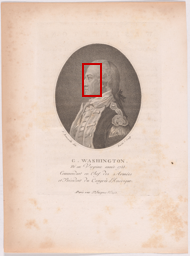

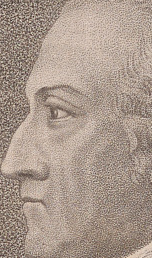

In [ ]:
# create empty faces column
portrait_df["faces"] = ""
portrait_df["face_urls"] = ""

# iterate through csv dataset
for idx,row in list(portrait_df.iterrows())[:5]:
  # parse mediaURLs field into a python list
  mediaURLs = json.loads(row["mediaURLs"].replace("'", '"'))

  # skip if no urls
  if len(mediaURLs) < 1:
    continue
  # download image
  try:
    r = requests.get(mediaURLs[0])
    oimg = PImage.open(BytesIO(r.content))
  except Exception as e:
    # If image cannot be opened, skip this row
    print("image cannot be opened, skipping:", idx)
    continue

  # dowload image
  r = requests.get(mediaURLs[0])
  oimg = PImage.open(BytesIO(r.content))

  # resize to height of 256
  iw,ih = oimg.size
  nh = 256
  nw = int(iw / ih * nh)
  img = oimg.resize((nw, nh))

  # detect faces
  output = face_detector.predict(img, verbose=False)

  # if no faces, skip
  if len(output) < 1 or len(output[0]) < 1:
    continue

  # list of face boxes
  faces_xyxy = output[0].boxes.xyxy.numpy()

  # # draw rect around faces (mostly for testing/debugging)
  # draw = PImageDraw.Draw(img)

  # for x0,y0,x1,y1 in faces_xyxy:
  #   draw.rectangle(((x0,y0), (x1,y1)), outline=(200,0,0), width=2)
  # display(img)

  # # face boxes are scaled to our smaller sized image
  # #   this unscales them back to the coordinates in the original image
  unscaled_faces_xyxy = []
  for x0,y0,x1,y1 in faces_xyxy:
    unscaled_faces_xyxy.append([
      int(x0 * iw / nw),
      int(y0 * ih / nh),
      int(x1 * iw / nw),
      int(y1 * ih / nh),
    ])

  # here the unscaled_faces_xyxy can be saved back to the dataset
  portrait_df.at[idx, "faces"] = unscaled_faces_xyxy

  # or we can use it to crop faces from images
  for x0,y0,x1,y1 in unscaled_faces_xyxy:
    face_img = oimg.crop((x0,y0,x1,y1))

    # display the face
    display(face_img)
    # and save to Cropped_Faces folder 
    #filename is index
    filename = f"Image_{idx}"
    face_img.save(f"Cropped_Faces/{filename}.jpg")

    #add face url to list
    face_url = f"https://github.com/nmolnar-parsons/revperiod_portraitfaces/blob/main/Cropped_Faces/{filename}.jpg?raw=true"
    portrait_df.at[idx, "face_urls"] += face_url + "; "

In [12]:
portrait_df.head()

,Unnamed: 0,collectionsURL,unitCode,dataSource,title,EDANid,guid,recordLink,lastUpdateDate,creditLine,...,indexed_places,indexed_topics,mediaCount,mediaURLs,thumbnail,Sitter,Artist,Clean_Date,faces,face_urls
0,0,https://collections.si.edu/search/detail/edanm...,SAAM,Smithsonian American Art Museum,George Washington,edanmdm:saam_XX108A,http://n2t.net/ark:/65665/vk7c06aa8a1-8da1-47c...,https://americanart.si.edu/collections/search/...,2024-11-22,"{""Credit Line"": ""Smithsonian American Art Muse...",...,[],"[Occupations, Men, Portraits, Political, Presi...",1,['https://ids.si.edu/ids/deliveryService?id=SA...,https://ids.si.edu/ids/iiif/SAAM-XX108A_1/full...,George Washington,William Winstanley,1803,"[[623, 441, 998, 968]]",https://github.com/nmolnar-parsons/revperiod_p...
1,1,https://collections.si.edu/search/detail/edanm...,SAAM,Smithsonian American Art Museum,Mourning Piece for George Washington,edanmdm:saam_1971.111,http://n2t.net/ark:/65665/vk7b2f8e20a-81fb-4f2...,https://americanart.si.edu/collections/search/...,2024-11-22,"{""Credit Line"": ""Smithsonian American Art Muse...",...,[Washington],"[Soldiers, Memorials, Occupations, Men, Monume...",1,['https://ids.si.edu/ids/deliveryService?id=SA...,https://ids.si.edu/ids/iiif/SAAM-1971.111_1/fu...,George Washington,Enoch G. Gridley,1810,"[[672, 933, 763, 1074], [336, 888, 402, 968]]",https://github.com/nmolnar-parsons/revperiod_p...
2,2,https://collections.si.edu/search/detail/edanm...,SAAM,Smithsonian American Art Museum,George Washington,edanmdm:saam_1971.102,http://n2t.net/ark:/65665/vk74652dc00-4f71-488...,https://americanart.si.edu/collections/search/...,2024-11-22,"{""Credit Line"": ""Smithsonian American Art Muse...",...,[],"[Uniforms, Landscapes, Animals, Occupations, C...",1,['https://ids.si.edu/ids/deliveryService?id=SA...,https://ids.si.edu/ids/iiif/SAAM-1971.102_1/fu...,George Washington,NaN,1800,"[[769, 398, 855, 518], [1167, 334, 1228, 416],...",https://github.com/nmolnar-parsons/revperiod_p...
3,3,https://collections.si.edu/search/detail/edanm...,NPG,National Portrait Gallery,Benjamin Franklin,edanmdm:npg_S_NPG.87.222,http://n2t.net/ark:/65665/sm4c77a42c7-3a26-4b6...,https://npg.si.edu/object/npg_S_NPG.87.222,2025-03-19,"{""Credit Line"": ""National Portrait Gallery, Sm...",...,[],"[Social Welfare and Reform, Business and Finan...",1,['https://ids.si.edu/ids/deliveryService?id=NP...,https://ids.si.edu/ids/iiif/NPG-S_NPG_87_222/f...,Benjamin Franklin,J. Pelicier,1782,"[[508, 425, 707, 736]]",https://github.com/nmolnar-parsons/revperiod_p...
4,4,https://collections.si.edu/search/detail/edanm...,NPG,National Portrait Gallery,George Washington,edanmdm:npg_S_NPG.85.297,http://n2t.net/ark:/65665/sm4b8e95381-ee00-454...,https://npg.si.edu/object/npg_S_NPG.85.297,2025-05-17,"{""Credit Line"": ""National Portrait Gallery, Sm...",...,[United States],"[Business and Finance, Congressional Gold Meda...",1,['https://ids.si.edu/ids/deliveryService?id=NP...,https://ids.si.edu/ids/iiif/NPG-S-NPG_85_297/f...,George Washington,Louis Charles Ruotte,1796,"[[644, 497, 796, 755]]",https://github.com/nmolnar-parsons/revperiod_p...
